<center><h1>Thai_Khang_HW4</h1></center>
<br>
<br>

Name: Khang Thai
<br>
Github Username: kunfupen
<br>
USC ID: 5721113147

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize, MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from scipy.stats import norm


Get the AReM Data Set

In [2]:
data = Path(r"C:\Users\kunfu\OneDrive\Documents\GitHub\DSCI-552\Homework\Homework 3, 4 Data\AReM")

### (b) Splitting Data

In [3]:
train_dataset = []
train_labels = []
test_dataset = []
test_labels = []

activities = ["bending1", "bending2", "cycling", "lying", "sitting", "standing", "walking"]
col_name = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23",]

for activity in activities:
    activity_files = data / activity
    if activity_files.exists():
        csv_files = sorted(activity_files.glob("*.csv"))

        for csv_file in csv_files:
            
            df = pd.read_csv(csv_file, comment = '#', header = None, names = col_name, on_bad_lines='skip', engine='python')

            df = df.drop('time', axis=1, errors='ignore')

            filename = csv_file.stem.lower()
            dataset_num = None
            if 'dataset' in filename:
                num_str = ''.join(filter(str.isdigit, filename.split('dataset')[1]))
                if num_str:
                    dataset_num = int(num_str)
                
            if activity in ['bending1', 'bending2']:
                if dataset_num in [1, 2]:
                    test_dataset.append(df)
                    test_labels.append(activity)
                else:
                    train_dataset.append(df)
                    train_labels.append(activity)
            else:
                if dataset_num in [1, 2, 3]:
                    test_dataset.append(df)
                    test_labels.append(activity)
                else:
                    train_dataset.append(df)
                    train_labels.append(activity)

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")


Training samples: 69
Testing samples: 19


### (c) Feature Extraction

In [4]:
def time_domain(df):
    features = {}
    cols = df.columns.tolist()
    for index, col in enumerate(cols, start=1):
        features[f'{col}_min'] = df[col].min()
        features[f'{col}_max'] = df[col].max()
        features[f'{col}_mean'] = df[col].mean()
        features[f'{col}_median'] = df[col].median()
        features[f'{col}_std'] = df[col].std()
        features[f'{col}_q1'] = df[col].quantile(0.25)
        features[f'{col}_q3'] = df[col].quantile(0.75)
    return features

all_feat = train_dataset + test_dataset
all_labels = train_labels + test_labels

feat_rows = [time_domain(df) for df in all_feat]
feat_mat = pd.DataFrame(feat_rows)
feat_mat['label'] = all_labels

print(feat_mat.shape)
feat_mat.head()

c:\Users\kunfu\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kunfu\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kunfu\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kunfu\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kunfu\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out,

(88, 43)


,avg_rss12_min,avg_rss12_max,avg_rss12_mean,avg_rss12_median,avg_rss12_std,avg_rss12_q1,avg_rss12_q3,var_rss12_min,var_rss12_max,var_rss12_mean,...,avg_rss23_q1,avg_rss23_q3,var_rss23_min,var_rss23_max,var_rss23_mean,var_rss23_median,var_rss23_std,var_rss23_q1,var_rss23_q3,label
0,35.00,47.40,43.954500,44.33,1.558835,43.00,45.00,0.0,1.70,0.426250,...,35.3625,36.50,0.0,1.79,0.493292,0.43,0.513506,0.00,0.94,bending1
1,33.00,47.75,42.179812,43.50,3.670666,39.15,45.00,0.0,3.00,0.696042,...,30.4575,36.33,0.0,2.18,0.613521,0.50,0.524317,0.00,1.00,bending1
2,33.00,45.75,41.678063,41.75,2.243490,41.33,42.75,0.0,2.83,0.535979,...,28.4575,31.25,0.0,1.79,0.383292,0.43,0.389164,0.00,0.50,bending1
3,37.00,48.00,43.454958,43.25,1.386098,42.50,45.00,0.0,1.58,0.378083,...,22.2500,24.00,0.0,5.26,0.679646,0.50,0.622534,0.43,0.87,bending1
4,36.25,48.00,43.969125,44.50,1.618364,43.31,44.67,0.0,1.50,0.413125,...,20.5000,23.75,0.0,2.96,0.555312,0.49,0.487826,0.00,0.83,bending1


## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

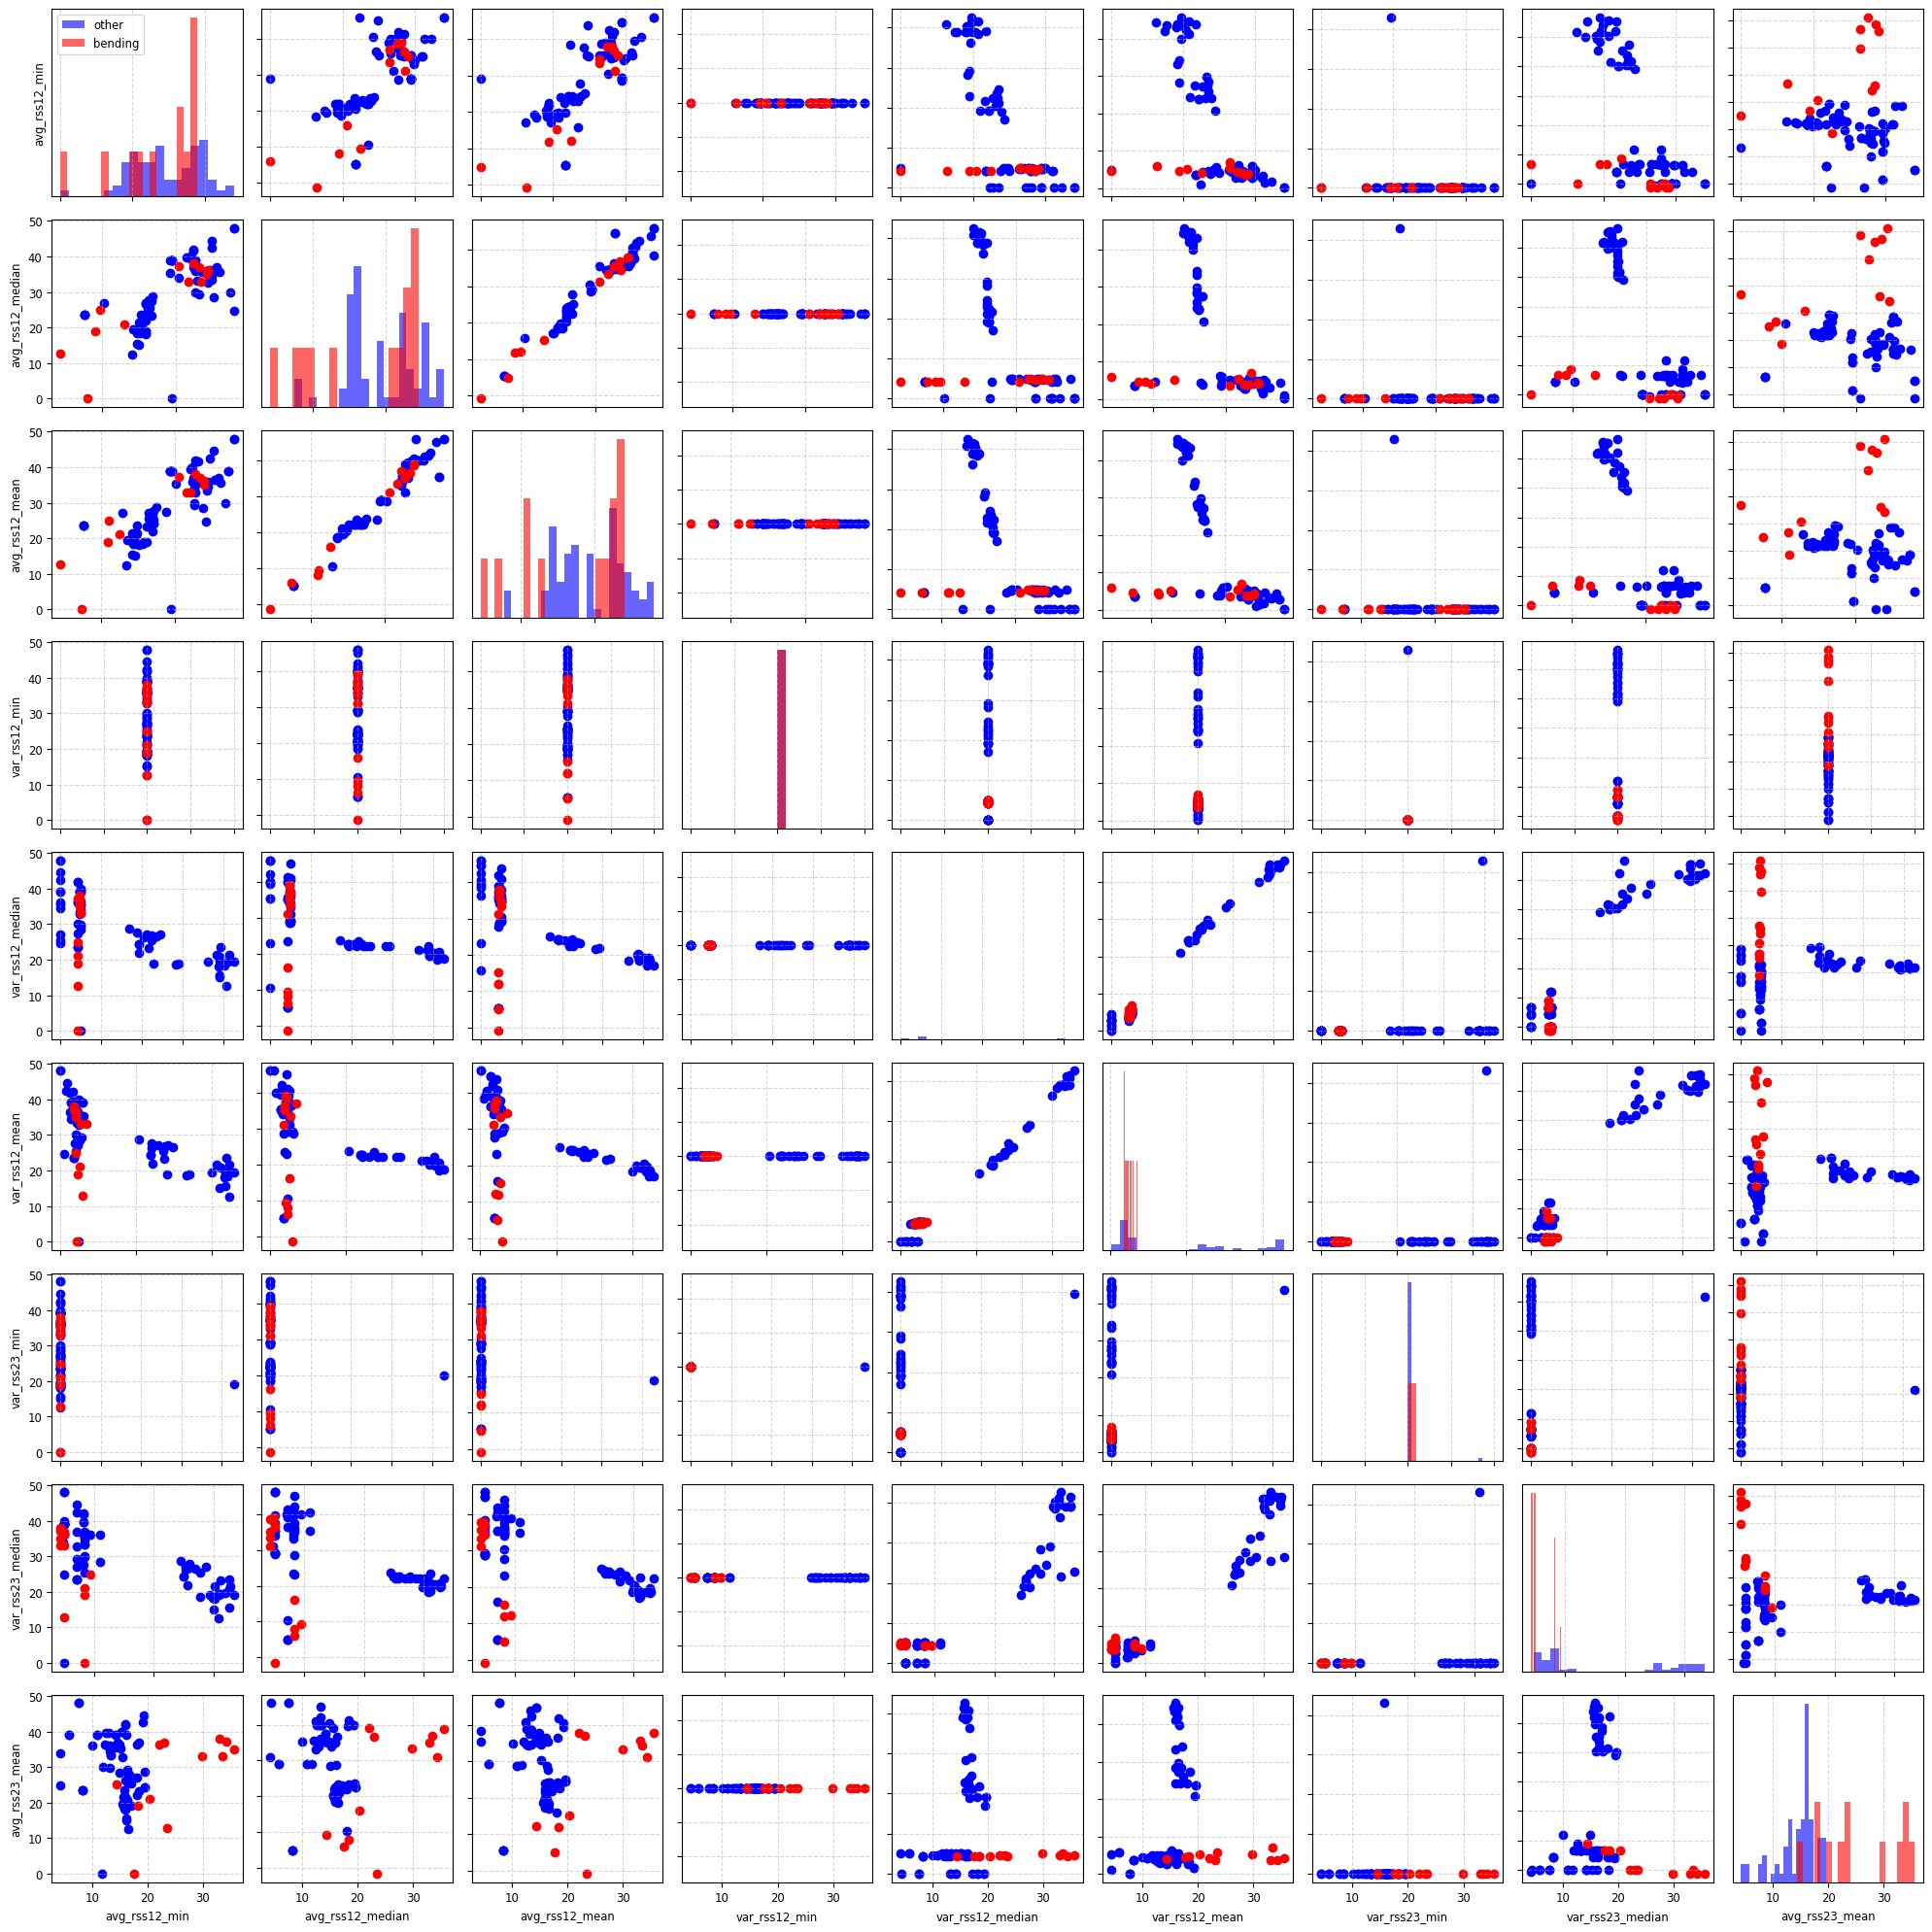

In [5]:
feat_mat['binary_label'] = feat_mat['label'].apply(lambda x: 'bending' if x in ['bending1', 'bending2'] else 'other')

feat = [
    'avg_rss12_min', 'avg_rss12_median', 'avg_rss12_mean',
    'var_rss12_min', 'var_rss12_median', 'var_rss12_mean',
    'var_rss23_min', 'var_rss23_median', 'avg_rss23_mean',
]

feat_label = [
    'TS1: min', 'TS1: median', 'TS1: mean',
    'TS2: min', 'TS2: median', 'TS2: mean',
    'TS6: min', 'TS6: median', 'TS6: mean',
]

colors = {'bending': 'red', 'other': 'blue'}

plot_data = feat_mat[feat + ['binary_label']].copy()
plot_data.columns = feat_label + ['binary_label']

fig, axes = plt.subplots(9, 9, figsize=(20, 20))

for i in range(9):
    for j in range(9):
        ax = axes[i, j]

        if i == j:
            for label in ['other', 'bending']:
                data = plot_data[plot_data['binary_label'] == label][feat_label[i]]
                ax.hist(data, bins=20, alpha=0.6, color=colors[label], density=True, label=label)

            if i == 0:
                ax.legend(['other', 'bending'], fontsize='small')
            
            ax.set_yticks([])
            ax.set_ylabel('')
        else:
            for label in ['other', 'bending']:
                mask = feat_mat['binary_label'] == label
                ax.scatter(
                    feat_mat[mask][feat[i]],
                    feat_mat[mask][feat[j]],
                    c=colors[label]
                )

        if i == 8:
            ax.set_xlabel(feat[j], fontsize='small')
            ax.tick_params(axis='x', labelsize='small')
        else:
            ax.set_xticklabels([])
            ax.tick_params(axis='x', labelsize='small')

        if j == 0:
            ax.set_ylabel(feat[i], fontsize='small')
            ax.tick_params(axis='y', labelsize='small')
        else:
            ax.set_yticklabels([])
            ax.tick_params(axis='y', labelsize='small')

        ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### ii. Splitted Plots

(69, 38)


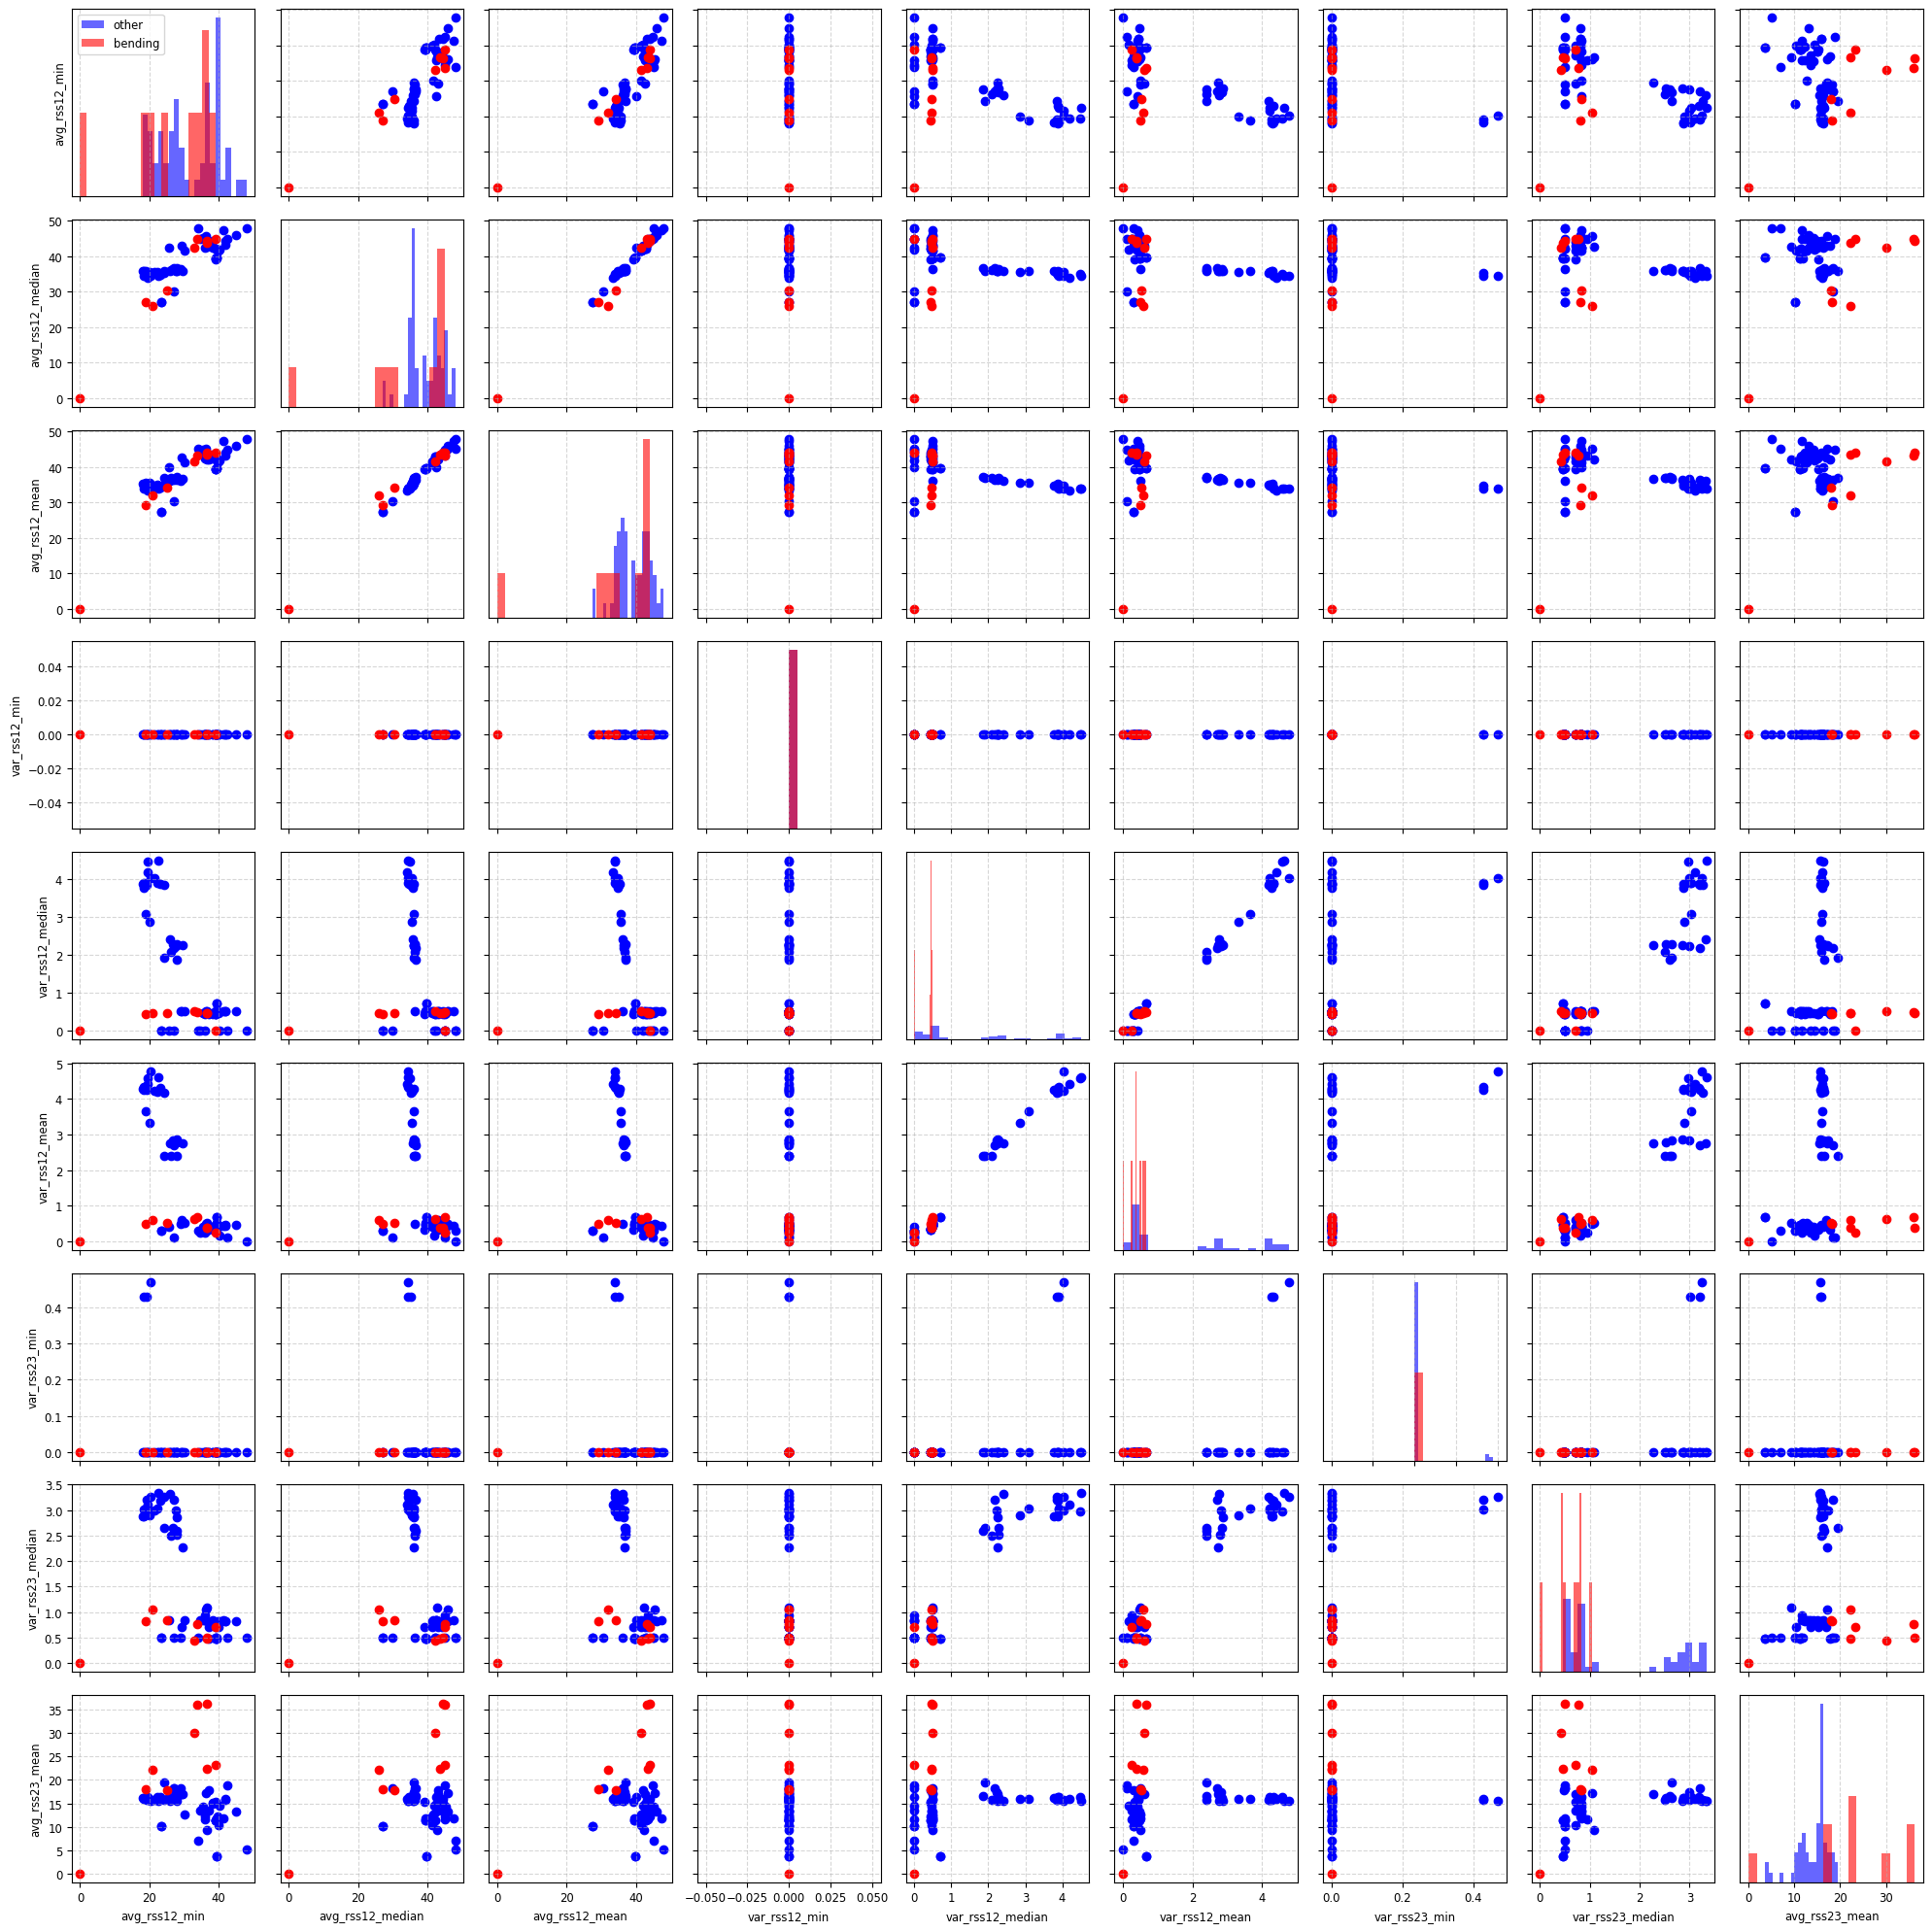

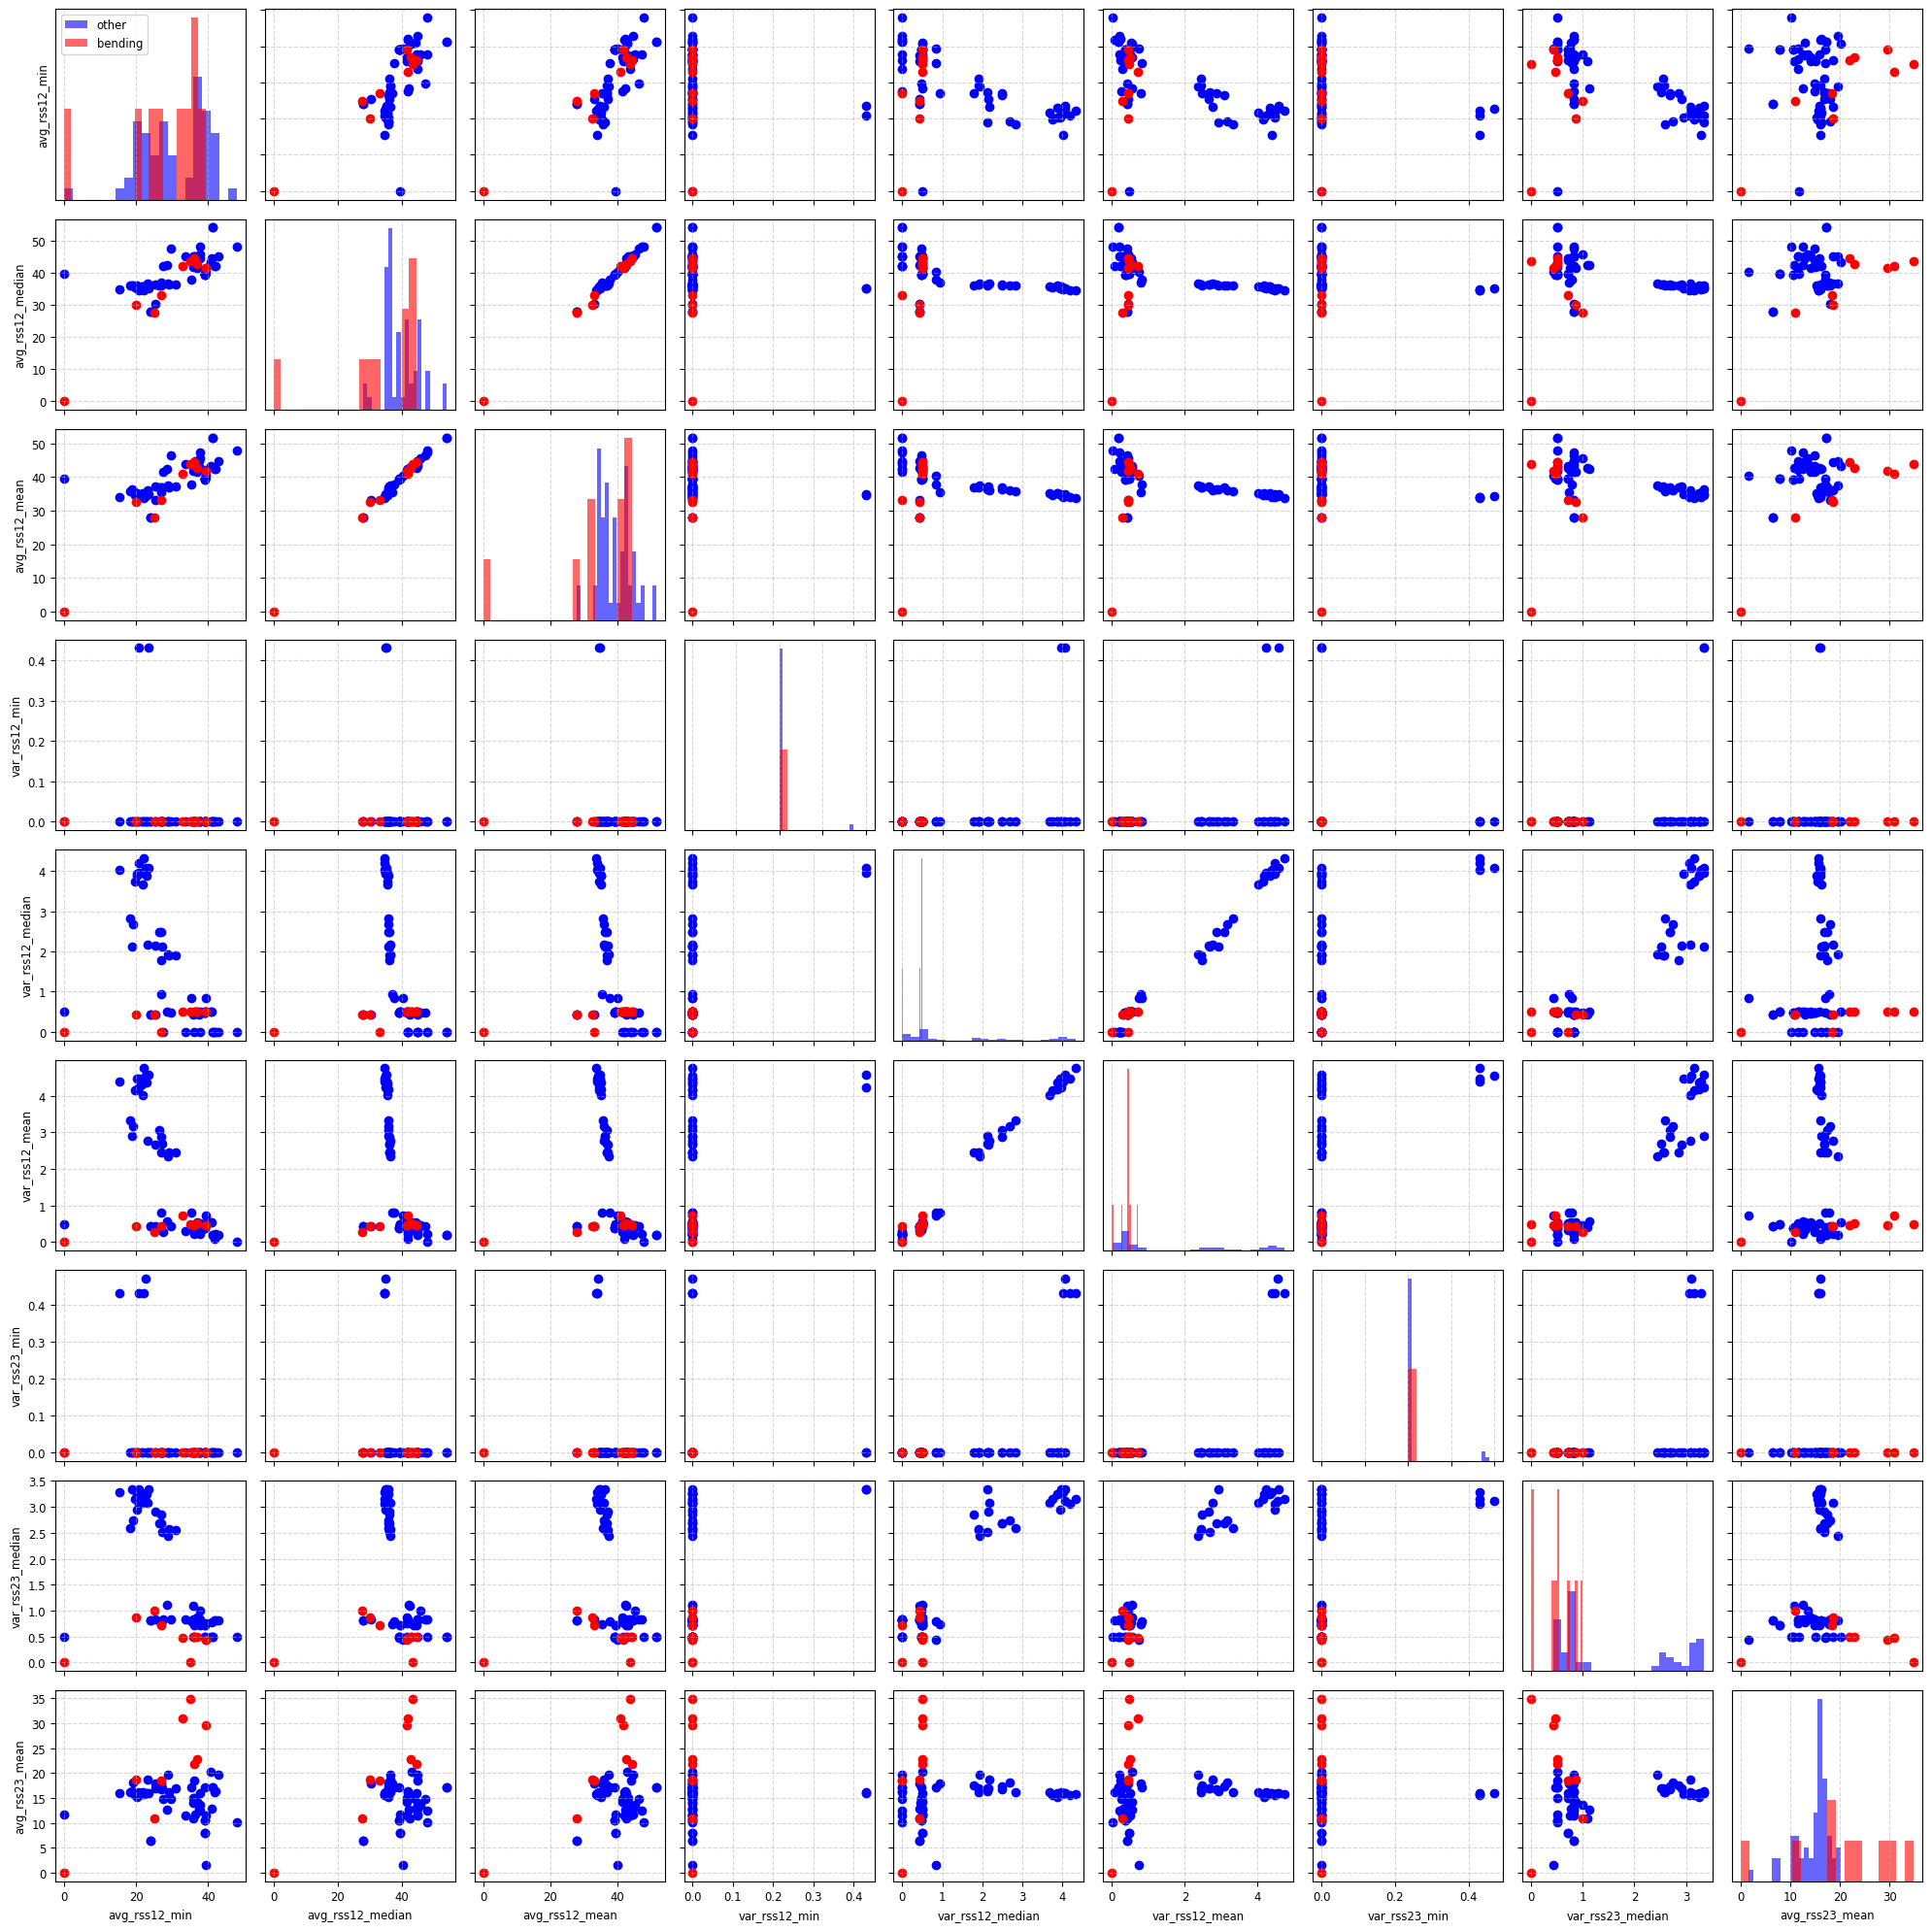

Both results show similar patterns and do not have much considerable differences


In [6]:
def split_feat(df):
    feat = {}

    df_num = df.apply(pd.to_numeric, errors='coerce')

    middle = len(df_num) // 2

    if middle == 0:
        middle = 1
    
    first_df = df_num.iloc[:middle]
    second_df = df_num.iloc[middle:]

    for col in df_num.columns:
        first_values = first_df[col].dropna()
        if len(first_values) == 0:
            feat[f'{col}_first_min'] = 0.0
            feat[f'{col}_first_mean'] = 0.0
            feat[f'{col}_first_median'] = 0.0
        else:
            feat[f'{col}_first_min'] = float(first_values.min())
            feat[f'{col}_first_mean'] = float(first_values.mean())
            feat[f'{col}_first_median'] = float(first_values.median())
    
        second_values = second_df[col].dropna()
        if len(second_values) == 0:
            feat[f'{col}_second_min'] = 0.0
            feat[f'{col}_second_mean'] = 0.0
            feat[f'{col}_second_median'] = 0.0
        else:
            feat[f'{col}_second_min'] = float(second_values.min())
            feat[f'{col}_second_mean'] = float(second_values.mean())
            feat[f'{col}_second_median'] = float(second_values.median())  
    return feat

train_split_row = [split_feat(df) for df in train_dataset]
train_split = pd.DataFrame(train_split_row).fillna(0)
train_split['label'] = train_labels
train_split['binary_label'] = train_split['label'].apply(lambda x: 'bending' if x in ['bending1', 'bending2'] else 'other')
print(train_split.shape)

feat_first = [
    'avg_rss12_first_min', 'avg_rss12_first_median', 'avg_rss12_first_mean',
    'var_rss12_first_min', 'var_rss12_first_median', 'var_rss12_first_mean',
    'var_rss23_first_min', 'var_rss23_first_median', 'avg_rss23_first_mean',
]

label_first = [
    'TS1 First: min', 'TS1 First: median', 'TS1 First: mean',
    'TS2 First: min', 'TS2 First: median', 'TS2 First: mean',
    'TS6 First: min', 'TS6 First: median', 'TS6 First: mean',
]

plot_data_first = train_split[feat_first + ['binary_label']].copy()
plot_data_first.columns = label_first + ['binary_label']

colors = {'bending': 'red', 'other': 'blue'}
fig, axes = plt.subplots(9, 9, figsize=(20, 20))

for i in range(9):
    for j in range(9):
        ax = axes[i, j]

        if i == j:
            for label in ['other', 'bending']:
                data = plot_data_first[plot_data_first['binary_label'] == label][label_first[i]]
                ax.hist(data, bins=20, alpha=0.6, color=colors[label], density=True, label=label)

            if i == 0:
                ax.legend(['other', 'bending'], fontsize='small')
            
            ax.set_yticks([])
            ax.set_ylabel('')
        else:
            for label in ['other', 'bending']:
                mask = plot_data_first['binary_label'] == label
                ax.scatter(
                    plot_data_first[mask][label_first[j]],
                    plot_data_first[mask][label_first[i]],
                    c=colors[label]
                )

        if i == 8:
            ax.set_xlabel(feat[j], fontsize='small')
            ax.tick_params(axis='x', labelsize='small')
        else:
            ax.set_xticklabels([])
            ax.tick_params(axis='x', labelsize='small')

        if j == 0:
            ax.set_ylabel(feat[i], fontsize='small')
            ax.tick_params(axis='y', labelsize='small')
        else:
            ax.set_yticklabels([])
            ax.tick_params(axis='y', labelsize='small')

        ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

feat_second = [
    'avg_rss12_second_min', 'avg_rss12_second_median', 'avg_rss12_second_mean',
    'var_rss12_second_min', 'var_rss12_second_median', 'var_rss12_second_mean',
    'var_rss23_second_min', 'var_rss23_second_median', 'avg_rss23_second_mean',
]

label_second = [
    'TS1 Second: min', 'TS1 Second: median', 'TS1 Second: mean',
    'TS2 Second: min', 'TS2 Second: median', 'TS2 Second: mean',
    'TS6 Second: min', 'TS6 Second: median', 'TS6 Second: mean',
]

plot_data_second = train_split[feat_second + ['binary_label']].copy()
plot_data_second.columns = label_second + ['binary_label']
colors = {'bending': 'red', 'other': 'blue'}
fig, axes = plt.subplots(9, 9, figsize=(20, 20))

for i in range(9):
    for j in range(9):
        ax = axes[i, j]

        if i == j:
            for label in ['other', 'bending']:
                data = plot_data_second[plot_data_second['binary_label'] == label][label_second[i]]
                ax.hist(data, bins=20, alpha=0.6, color=colors[label], density=True, label=label)

            if i == 0:
                ax.legend(['other', 'bending'], fontsize='small')
            
            ax.set_yticks([])
            ax.set_ylabel('')
        else:
            for label in ['other', 'bending']:
                mask = plot_data_second['binary_label'] == label
                ax.scatter(
                    plot_data_second[mask][label_second[j]],
                    plot_data_second[mask][label_second[i]],
                    c=colors[label]
                )

        if i == 8:
            ax.set_xlabel(feat[j], fontsize='small')
            ax.tick_params(axis='x', labelsize='small')
        else:
            ax.set_xticklabels([])
            ax.tick_params(axis='x', labelsize='small')

        if j == 0:
            ax.set_ylabel(feat[i], fontsize='small')
            ax.tick_params(axis='y', labelsize='small')
        else:
            ax.set_yticklabels([])
            ax.tick_params(axis='y', labelsize='small')

        ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("Both results show similar patterns and do not have much considerable differences")

#### iii. Time Series Segments

In [7]:
def extract(dfm, segments):
    feat = {}
    cols = dfm.columns.tolist()

    if len(dfm) < segments:
        segments = max(1, len(dfm))

    for seg, index in enumerate(np.array_split(np.arange(len(dfm)), segments), 1):
        if len(index) == 0:
            continue
        slice = dfm.iloc[index].apply(pd.to_numeric, errors='coerce')
        for col in cols:
            base = f'{col}_seg{seg}'
            value = slice[col].dropna().to_numpy()
            if value.size == 0:
                feat[f'{base}_min'] = 0.0
                feat[f'{base}_max'] = 0.0
                feat[f'{base}_mean'] = 0.0
                feat[f'{base}_median'] = 0.0
                feat[f'{base}_std'] = 0.0
                feat[f'{base}_q1'] = 0.0
                feat[f'{base}_q3'] = 0.0
            elif value.size == 1:
                feat[f'{base}_min'] = float(value[0])
                feat[f'{base}_max'] = float(value[0])
                feat[f'{base}_mean'] = float(value[0])
                feat[f'{base}_median'] = float(value[0])
                feat[f'{base}_std'] = 0.0
                feat[f'{base}_q1'] = float(value[0])
                feat[f'{base}_q3'] = float(value[0])
            else:
                feat[f'{base}_min'] = float(np.min(value))
                feat[f'{base}_max'] = float(np.max(value))
                feat[f'{base}_mean'] = float(np.mean(value))
                feat[f'{base}_median'] = float(np.median(value))
                feat[f'{base}_std'] = float(np.std(value))
                feat[f'{base}_q1'] = float(np.quantile(value, 0.25))
                feat[f'{base}_q3'] = float(np.quantile(value, 0.75))
    return feat

def p_va(model, x):
    prob = model.predict_proba(x)[:, 1]
    w = np.diag(prob * (1 - prob))
    XtWX = x.T @ w @ x
    cov = np.linalg.pinv(XtWX)
    se = np.sqrt(np.diag(cov))
    z = model.coef_[0] / se
    p_values = 2 * (1 - norm.cdf(np.abs(z)))
    return p_values, se

y_train = np.array([1 if lbl in ['bending1', 'bending2'] else 0 for lbl in train_labels])

best_acc = 0
best_config = None
results = []

for l in range(1, 21):
    print(f"Evaluating for l = {l}")
    x_l = pd.DataFrame([extract(df, l) for df in train_dataset]).fillna(0.0)
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_l)

    rfecv = RFECV(
        estimator=LogisticRegression(
            solver="lbfgs",
            C=5.0,
            max_iter=300,
            class_weight="balanced",
            random_state=42
        ),
        step=1,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy',
        min_features_to_select=15,
        n_jobs=-1
    )
    rfecv.fit(x_scaled, y_train)

    optimal = np.where(rfecv.cv_results_['n_features'] == rfecv.n_features_)[0][0]

    cv_score = rfecv.cv_results_['mean_test_score'][optimal]
    cv_std = rfecv.cv_results_['std_test_score'][optimal]

    results.append({
        'l': l,
        'p': rfecv.n_features_,
        'cv_accuracy': cv_score,
        'cv_std': cv_std
    })

    if cv_score > best_acc:
        best_acc = cv_score
        best_config = {
            'l': l,
            'p': rfecv.n_features_,
            'cv_accuracy': cv_score,
            'cv_std': cv_std,
            'rfecv': rfecv,
            'scaler': scaler,
            'x_scaled': x_scaled
        }
    

results_df = pd.DataFrame(results)
display(results_df.sort_values('cv_accuracy', ascending=False))

best = results_df.loc[results_df['cv_accuracy'].idxmax()]
print(f"Best l: {best.l}, p: {best.p}")
print(f"CV Accuracy: {best.cv_accuracy:.4f} ± {best.cv_std:.4f}")


best_l = int(best.l)
X_best = pd.DataFrame([extract(df, best_l) for df in train_dataset]).fillna(0.0)
scaler_best = StandardScaler()
X_scaled_best = scaler_best.fit_transform(X_best)

rfecv_best = RFECV(
    estimator=LogisticRegression(
        solver="lbfgs",
        penalty="l2",
        C=1.0,
        max_iter=200,
        tol=1e-3,
        class_weight="balanced",
        random_state=42
    ),
    step=1,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    min_features_to_select=1,
    n_jobs=-1
)

rfecv_best.fit(X_scaled_best, y_train)
x_train_sel = rfecv_best.transform(X_scaled_best)

model_final = LogisticRegression(
    solver="lbfgs",
    penalty="l2",
    C=1.0,
    max_iter=200,
    tol=1e-2,
    class_weight="balanced",
    random_state=42
)
model_final.fit(x_train_sel, y_train)

selected_feat = X_best.columns[rfecv_best.get_support()]

p_val, std_err = p_va(model_final, x_train_sel)
p_table = pd.DataFrame({
    'Feature': selected_feat,
    'Coefficient': model_final.coef_[0],
    'Std_Error': std_err,
    'Z_score': model_final.coef_[0] / std_err,
    'P_Value': p_val
}).sort_values(by='P_Value')
display(p_table)

Evaluating for l = 1
Evaluating for l = 2
Evaluating for l = 3
Evaluating for l = 4
Evaluating for l = 5
Evaluating for l = 6
Evaluating for l = 7
Evaluating for l = 8
Evaluating for l = 9
Evaluating for l = 10
Evaluating for l = 11
Evaluating for l = 12
Evaluating for l = 13
Evaluating for l = 14
Evaluating for l = 15
Evaluating for l = 16
Evaluating for l = 17
Evaluating for l = 18
Evaluating for l = 19
Evaluating for l = 20


,l,p,cv_accuracy,cv_std
18,19,16,0.957143,0.034993
16,17,17,0.957143,0.034993
0,1,16,0.942857,0.028571
3,4,31,0.942857,0.028571
17,18,15,0.942857,0.053452
14,15,20,0.942857,0.028571
7,8,54,0.942857,0.053452
11,12,96,0.942857,0.028571
13,14,15,0.941758,0.029199
19,20,15,0.941758,0.029199


Best l: 17.0, p: 17.0
CV Accuracy: 0.9571 ± 0.0350


,Feature,Coefficient,Std_Error,Z_score,P_Value
3,avg_rss12_seg10_max,-1.537834,0.622397,-2.470826,0.013480
4,avg_rss23_seg16_std,-0.969829,0.717634,-1.351425,0.176559
2,avg_rss23_seg3_median,1.054403,1.462263,0.721076,0.470863
0,avg_rss23_seg2_min,0.981200,1.393742,0.704004,0.481431
1,avg_rss23_seg3_min,0.942222,1.356002,0.694853,0.487147


#### iv. Confusion Matrix

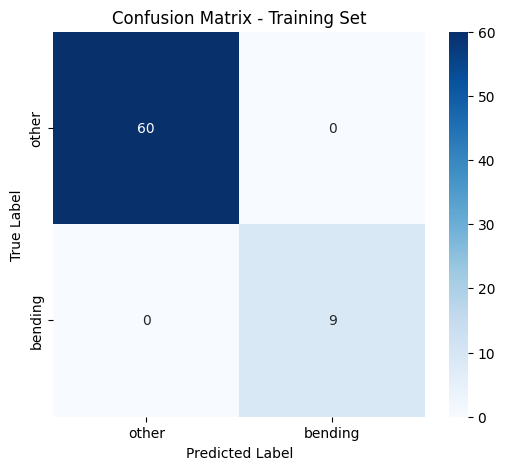

Training AUC: 1.0000


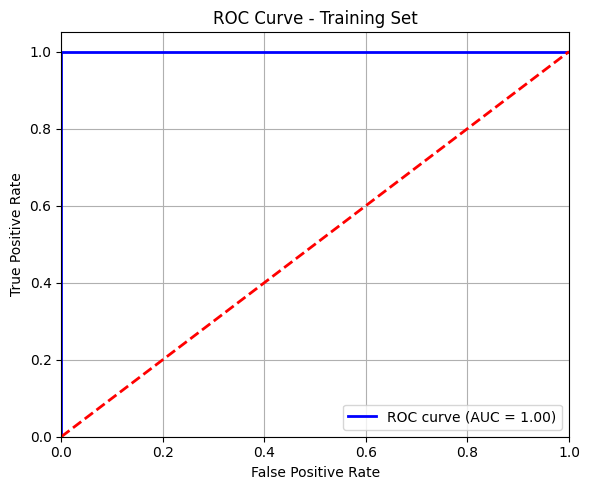

AUC Score: 1.0000
Features: ['avg_rss23_seg2_min', 'avg_rss23_seg3_min', 'avg_rss23_seg3_median', 'avg_rss12_seg10_max', 'avg_rss23_seg16_std']
Coefficients: [0.9811995282355124, 0.9422215692459178, 1.0544025830881487, -1.5378343116735602, -0.969828845445338]
Confusion Matrix:
[[60  0]
 [ 0  9]]


In [8]:
y_train_pred = model_final.predict(x_train_sel)
y_train_pred_prob = model_final.predict_proba(x_train_sel)[:, 1]

cm = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['other', 'bending'], yticklabels=['other', 'bending'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Training Set')
plt.show()

fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_prob)
roc_curve_auc = auc(fpr, tpr)
print(f"Training AUC: {roc_curve_auc:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_curve_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)

print(f"AUC Score: {roc_curve_auc:.4f}")

coef = model_final.coef_[0]
intercept = model_final.intercept_[0]

print(f'Features: {selected_feat.tolist()}')
print(f'Coefficients: {coef.tolist()}')
print(f'Confusion Matrix:\n{cm}')




#### v. Test Classifier

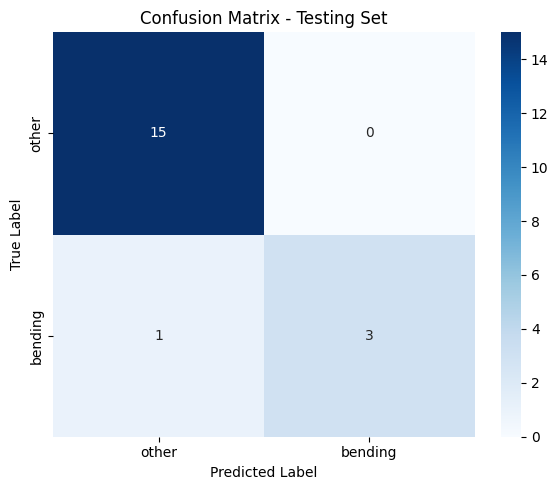

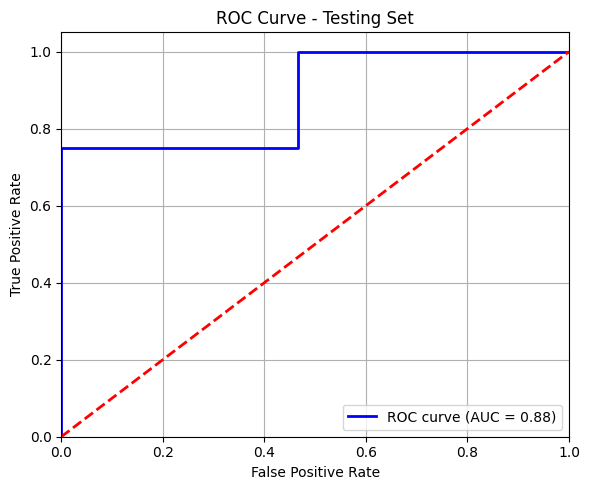

Testing AUC: 0.8833
Testing Accuracy: 0.9474
Train cross-validation accuracy: 0.9571 ± 0.0350
Confusion Matrix:
[[15  0]
 [ 1  3]]
The classifer shows high accuracy, high AUC, and consistant training and testing performance.


In [9]:
y_test = np.array([1 if lbl in ['bending1', 'bending2'] else 0 for lbl in test_labels])

x_test = pd.DataFrame([extract(df, best_l) for df in test_dataset]).fillna(0.0)
x_test_scaled = scaler_best.transform(x_test)
x_test_sel = rfecv_best.transform(x_test_scaled)

y_test_pred = model_final.predict(x_test_sel)
y_test_pred_prob = model_final.predict_proba(x_test_sel)[:, 1]

cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['other', 'bending'], yticklabels=['other', 'bending'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Testing Set')
plt.tight_layout()
plt.show()

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(6, 5))
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Testing Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Testing AUC: {roc_auc_test:.4f}")
print(f"Testing Accuracy: {accuracy_test:.4f}")
print(f"Train cross-validation accuracy: {best.cv_accuracy:.4f} ± {best.cv_std:.4f}")
print(f"Confusion Matrix:\n{cm_test}")
print("The classifer shows high accuracy, high AUC, and consistant training and testing performance.")




#### vi. Separation

The classes seem to be well-separated and do not cause instability. Training accuracy shows 100% and testing accuracy shows 94.74%. Cross validation accuracy is also closely matched to the test accuracy indicating that the model is not overfitting.

#### vii. Imbalance

18
Original Intercept: -1.6878
Adjusted Intercept: -3.5849
[[9 0]
 [0 9]]


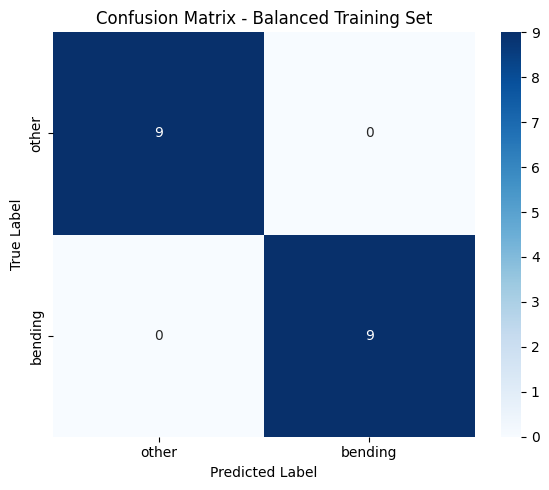

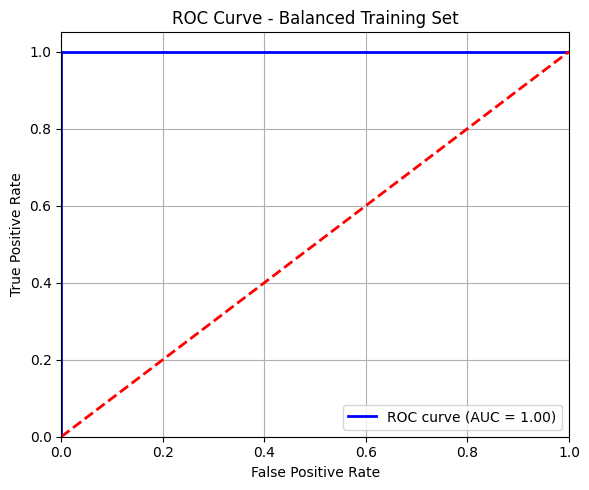

Balanced Training Accuracy: 1.0000
Train cross-validation accuracy: 0.9571 ± 0.0350
Balanced Training AUC: 1.0000
Confusion Matrix:
[[9 0]
 [0 9]]


In [10]:
x_train_final = pd.DataFrame([extract(df, best_l) for df in train_dataset]).fillna(0.0)
x_majority = x_train_final[y_train == 0]
x_minority = x_train_final[y_train == 1]

x_maj_down = resample(x_majority, n_samples=len(x_minority), random_state=42)

x_balanced = pd.concat([x_maj_down, x_minority])
y_balanced = np.array([0]*len(x_maj_down) + [1]*len(x_minority))

shuffled_indices = np.random.permutation(len(x_balanced))
x_balanced = x_balanced.iloc[shuffled_indices].reset_index(drop=True)
y_balanced = y_balanced[shuffled_indices]

x_balanced_scaled = scaler_best.transform(x_balanced)
x_balanced_sel = rfecv_best.transform(x_balanced_scaled)

model_balanced = LogisticRegression(
    solver="lbfgs",
    penalty="l2",
    C=1.0,
    max_iter=200,
    tol=1e-2,
    random_state=42
)
model_balanced.fit(x_balanced_sel, y_balanced)
print(len(x_balanced))

pop = len(y_train[y_train == 1]) / len(y_train)
sample = 0.5

adj = np.log(pop / (1 - pop)) - np.log(sample / (1 - sample))
intercept_balanced = model_balanced.intercept_[0]
intercept_adjusted = intercept_balanced + adj

print(f"Original Intercept: {intercept_balanced:.4f}")
print(f"Adjusted Intercept: {intercept_adjusted:.4f}")

model_balanced.intercept_[0] = intercept_adjusted

y_balanced_pred = model_balanced.predict(x_balanced_sel)
y_balanced_pred_prob = model_balanced.predict_proba(x_balanced_sel)[:, 1]

cm_test_balanced = confusion_matrix(y_balanced, y_balanced_pred)
print(cm_test_balanced)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=['other', 'bending'], yticklabels=['other', 'bending'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Balanced Training Set')
plt.tight_layout()
plt.show()

fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_balanced, y_balanced_pred_prob)
roc_auc_balanced = auc(fpr_balanced, tpr_balanced)

plt.figure(figsize=(6, 5))
plt.plot(fpr_balanced, tpr_balanced, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_balanced:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Balanced Training Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

accuracy_balanced = accuracy_score(y_balanced, y_balanced_pred)
print(f"Balanced Training Accuracy: {accuracy_balanced:.4f}")
print(f"Train cross-validation accuracy: {best.cv_accuracy:.4f} ± {best.cv_std:.4f}")
print(f"Balanced Training AUC: {roc_auc_balanced:.4f}")
print(f"Confusion Matrix:\n{cm_test_balanced}")


### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [11]:
c_val = np.logspace(-3, 3, 20)

l1_res = []

for l in range(1, 21):
    x_l = pd.DataFrame([extract(df, l) for df in train_dataset]).fillna(0.0)

    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_l)
    lr_model = LogisticRegressionCV(
        Cs=c_val,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        penalty='l1',
        solver='liblinear',
        max_iter=500,
        scoring='accuracy',
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
    lr_model.fit(x_scaled, y_train)
    best_c = lr_model.C_[0]

    cv_scores = lr_model.scores_[1]
    c_index = np.where(c_val == best_c)[0][0] if best_c in c_val else np.argmin(np.abs(c_val - best_c))

    mean_cv_score = np.mean(cv_scores, axis=0)[c_index]
    std_cv_score = np.std(cv_scores, axis=0)[c_index]
    
    feat_sel = np.sum(lr_model.coef_[0] != 0)

    l1_res.append({
        'l': l,
        'C': best_c,
        'p': feat_sel,
        'cv_accuracy': mean_cv_score,
        'cv_std': std_cv_score,
        'model': lr_model,
        'scaler': scaler,
        'features': x_l.columns.tolist()
    })

l1_res_df = pd.DataFrame([
    {
        'l': res['l'],
        'C': res['C'],
        'p': res['p'],
        'cv_accuracy': res['cv_accuracy'],
        'cv_std': res['cv_std']
    }
    for res in l1_res
])


best_index = l1_res_df['cv_accuracy'].idxmax()
best_l1 = l1_res[best_index]
print(f"Best l: {best_l1['l']}")
print(f"l1 Score: {best_l1['l']} before: {best_l1['cv_accuracy']:.1f}")

best_l1_model = best_l1['model']
best_l1_coef = best_l1_model.coef_[0]
best_l1_feat = np.array(best_l1['features'])

non_zero = best_l1_coef != 0
selected_features = best_l1_feat[non_zero]
selected_coef = best_l1_coef[non_zero]

feat_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': selected_coef
})
print(feat_df.to_string(index = False))

x_l1_final = pd.DataFrame([extract(df, best_l1['l']) for df in train_dataset]).fillna(0.0)
x_l1_scaled = best_l1['scaler'].transform(x_l1_final)

y_train_pred_l1 = best_l1_model.predict(x_l1_scaled)
y_train_pred_prob_l1 = best_l1_model.predict_proba(x_l1_scaled)[:, 1]

cm_l1 = confusion_matrix(y_train, y_train_pred_l1)
acc_train_l1 = accuracy_score(y_train, y_train_pred_l1)

print(cm_l1)
print(f"Train accuracy score: {acc_train_l1:.4f}")

x_test_l1 = pd.DataFrame([extract(df, best_l1['l']) for df in test_dataset]).fillna(0.0)
x_test_l1_scaled = best_l1['scaler'].transform(x_test_l1)

y_test_pred_l1 = best_l1['model'].predict(x_test_l1_scaled)
y_test_pred_prob_l1 = best_l1['model'].predict_proba(x_test_l1_scaled)[:, 1]

cm_test_l1 = confusion_matrix(y_test, y_test_pred_l1)
acc_test_l1 = accuracy_score(y_test, y_test_pred_l1)

print(cm_test_l1)
print(f"Test accuracy score: {acc_test_l1:.1f}")





Best l: 13
l1 Score: 13 before: 1.0
            Feature  Coefficient
 avg_rss23_seg1_max     0.094365
 avg_rss12_seg2_max    -0.260799
 avg_rss23_seg2_min     1.836297
  avg_rss12_seg8_q3    -0.191155
 avg_rss12_seg9_max    -0.514160
 avg_rss13_seg9_min     0.118002
avg_rss12_seg10_max    -0.142601
avg_rss13_seg10_std    -0.212269
var_rss23_seg10_max    -0.016451
avg_rss23_seg12_min     0.465610
avg_rss23_seg12_std    -0.075004
var_rss23_seg12_max    -0.560643
[[60  0]
 [ 0  9]]
Train accuracy score: 1.0000
[[15  0]
 [ 0  4]]
Test accuracy score: 1.0


#### ii. Comparison

L1 has a better testing accuracy performance at 100%. L1 also uses less features compared to standard logistic regression and is easier to implement. 

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

Best l: 1
Multinomial Score: 1 before: 0.9
Test confusion matrix:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]
Test accuracy score: 0.8947368421052632


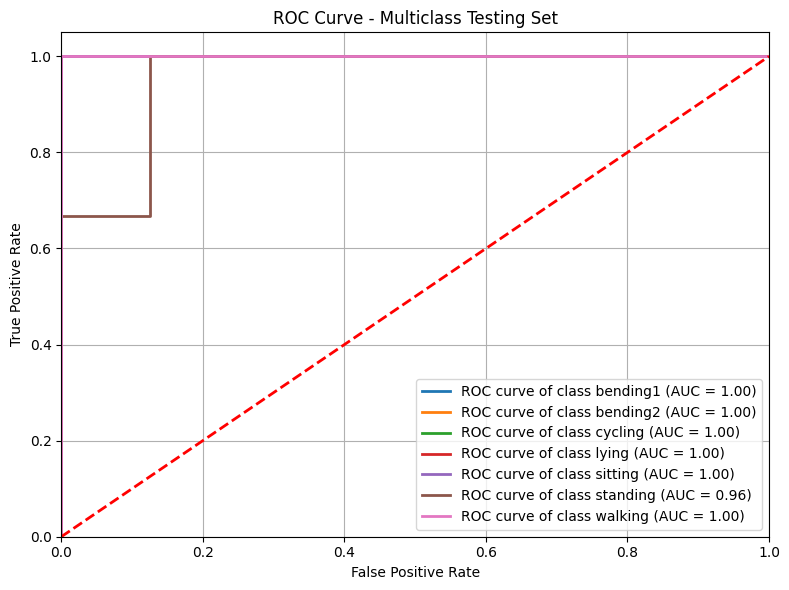

In [12]:
label_encoder = LabelEncoder()

all_feat = sorted(set(train_labels + test_labels))
label_encoder.fit(all_feat)

y_train_multi = label_encoder.transform(train_labels)
y_test_multi = label_encoder.transform(test_labels)

for i, activity in enumerate(label_encoder.classes_):
    train_count = np.sum(y_train_multi == i)
    test_count = np.sum(y_test_multi == i)

c_val_multi = np.logspace(-3, 3, 20)

multi_res = []

for l in range(1, 21, 2):
    x_l = pd.DataFrame([extract(df, l) for df in train_dataset]).fillna(0.0)

    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_l)

    mult_model = LogisticRegressionCV(
        Cs=c_val_multi,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        penalty='l1',
        solver='saga',
        max_iter=1000,
        tol = 1e-3,
        scoring='accuracy',
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )

    mult_model.fit(x_scaled, y_train_multi)
    best_c = mult_model.C_[0]

    cv_scores = mult_model.scores_[1]
    c_index = np.where(c_val_multi == best_c)[0][0] if best_c in c_val_multi else np.argmin(np.abs(c_val_multi - best_c))

    mean_cv_score = np.mean(cv_scores, axis=0)[c_index]
    std_cv_score = np.std(cv_scores, axis=0)[c_index]

    unique_features = np.sum(np.any(mult_model.coef_ != 0, axis=0))
    total_non_zero = np.sum(mult_model.coef_ != 0)

    multi_res.append({
        'l': l,
        'C': best_c,
        'p_unique': unique_features,
        'p_total': total_non_zero,
        'total_features': x_l.shape[1],
        'cv_accuracy': mean_cv_score,
        'cv_std': std_cv_score,
        'model': mult_model,
        'scaler': scaler,
        'features': x_l.columns.tolist()
    })

l_multi_res_df = pd.DataFrame([
    {
        'l': res['l'],
        'C': res['C'],
        'p_total': res['p_total'],
        'p_unique': res['p_unique'],
        'cv_accuracy': res['cv_accuracy'],
        'cv_std': res['cv_std']
    }
    for res in multi_res
])

best_index_multi = l_multi_res_df['cv_accuracy'].idxmax()
best_multi = multi_res[best_index_multi]
print(f"Best l: {best_multi['l']}")
print(f"Multinomial Score: {best_multi['l']} before: {best_multi['cv_accuracy']:.1f}")

best_multi_model = best_multi['model']
best_multi_coef = best_multi_model.coef_
best_multi_feat = np.array(best_multi['features'])

x_test_multi = pd.DataFrame([extract(df, best_multi['l']) for df in test_dataset]).fillna(0.0)
x_test_multi_scaled = best_multi['scaler'].transform(x_test_multi)

y_test_pred_multi = best_multi_model.predict(x_test_multi_scaled)
y_test_pred_prob_multi = best_multi_model.predict_proba(x_test_multi_scaled)

cm_test_multi = confusion_matrix(y_test_multi, y_test_pred_multi)
acc_test_multi = accuracy_score(y_test_multi, y_test_pred_multi)
print("Test confusion matrix:")
print(cm_test_multi)
print(f"Test accuracy score: {acc_test_multi}")

n_class = len(label_encoder.classes_)

y_test_bin = label_binarize(y_test_multi, classes=range(n_class))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_class):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_prob_multi[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multiclass Testing Set')
plt.legend(loc="lower right")
plt.grid(True) 
plt.tight_layout()
plt.show()


#### ii. Naive Bayes

In [14]:
gauss_res = []

for l in range(1, 21, 2):
    x_train_nb = pd.DataFrame([extract(df, l) for df in train_dataset]).fillna(0.0)
    x_test_nb = pd.DataFrame([extract(df, l) for df in test_dataset]).fillna(0.0)

    scaler_nb = StandardScaler()
    x_train_scaled = scaler_nb.fit_transform(x_train_nb)
    x_test_scaled = scaler_nb.transform(x_test_nb)

    gauss_nb = GaussianNB()
    gauss_nb.fit(x_train_scaled, y_train_multi)

    cv_scores = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    for train_idx, val_idx in skf.split(x_train_scaled, y_train_multi):
        x_tr, x_val = x_train_scaled[train_idx], x_train_scaled[val_idx]
        y_tr, y_val = y_train_multi[train_idx], y_train_multi[val_idx]

        gauss_nb_cv = GaussianNB()
        gauss_nb_cv.fit(x_tr, y_tr)
        cv_scores.append(gauss_nb_cv.score(x_val, y_val))

    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)

    y_test_pred_nb = gauss_nb.predict(x_test_scaled)
    y_test_prob_nb = gauss_nb.predict_proba(x_test_scaled)

    test_acc_nb = accuracy_score(y_test_multi, y_test_pred_nb)

    gauss_res.append({
        'l': l,
        'cv_accuracy': mean_cv_score,
        'cv_std': std_cv_score,
        'test_accuracy': test_acc_nb,
        'model': gauss_nb,
        'scaler': scaler_nb,
        'features': x_train_nb.columns.tolist(),
        'y_pred': y_test_pred_nb,
        'y_prob': y_test_prob_nb
    })

gauss_df = pd.DataFrame([{
    'l': r['l'],
    'cv_accuracy': r['cv_accuracy'],
    'cv_std': r['cv_std'],
    'test_accuracy': r['test_accuracy']
} for r in gauss_res])

best_index_gauss = gauss_df['cv_accuracy'].idxmax()
best_gauss = gauss_res[best_index_gauss]

cm_gaussnb = confusion_matrix(y_test_multi, best_gauss['y_pred'])
print("Guassian Naive Bayes:")
print("Test confusion matrix:")
print(cm_gaussnb)
print(f"Test accuracy score: {accuracy_score(y_test_multi, best_gauss['y_pred']):.4f}")

multinorm_res = []

for l in range(1, 21, 2):
    x_train_nb = pd.DataFrame([extract(df, l) for df in train_dataset]).fillna(0.0)
    x_test_nb = pd.DataFrame([extract(df, l) for df in test_dataset]).fillna(0.0)

    scaler_mnb = MinMaxScaler()
    x_train_scaled = scaler_mnb.fit_transform(x_train_nb)
    x_test_scaled = scaler_mnb.transform(x_test_nb)

    multinorm_nb = MultinomialNB()
    multinorm_nb.fit(x_train_scaled, y_train_multi)

    cv_scores = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    for train_idx, val_idx in skf.split(x_train_scaled, y_train_multi):
        x_tr, x_val = x_train_scaled[train_idx], x_train_scaled[val_idx]
        y_tr, y_val = y_train_multi[train_idx], y_train_multi[val_idx]

        multinorm_nb_cv = MultinomialNB()
        multinorm_nb_cv.fit(x_tr, y_tr)
        cv_scores.append(multinorm_nb_cv.score(x_val, y_val))

    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)

    y_test_pred_mnb = multinorm_nb.predict(x_test_scaled)
    y_test_prob_mnb = multinorm_nb.predict_proba(x_test_scaled)

    test_acc_mnb = accuracy_score(y_test_multi, y_test_pred_mnb)

    multinorm_res.append({
        'l': l,
        'cv_accuracy': mean_cv_score,
        'cv_std': std_cv_score,
        'test_accuracy': test_acc_mnb,
        'model': multinorm_nb,
        'scaler': scaler_mnb,
        'features': x_train_nb.columns.tolist(),
        'y_pred': y_test_pred_mnb,
        'y_prob': y_test_prob_mnb
    })

multinorm_df = pd.DataFrame([{
    'l': r['l'],
    'cv_accuracy': r['cv_accuracy'],
    'cv_std': r['cv_std'],
    'test_accuracy': r['test_accuracy']
} for r in multinorm_res])

best_index_mnb = multinorm_df['cv_accuracy'].idxmax()
best_mnb = multinorm_res[best_index_mnb]

cm_mnb = confusion_matrix(y_test_multi, best_mnb['y_pred'])
print("Multinomial Naive Bayes:")
print("Test confusion matrix:")
print(cm_mnb)
print(f"Test accuracy score: {best_mnb['test_accuracy']}")

compare = {
    'L1-Logistic Regression': {
        'cv_accuracy': best_multi['cv_accuracy'],
        'test_accuracy': acc_test_multi
    },
    'Gaussian Naive Bayes': {
        'cv_accuracy': best_gauss['cv_accuracy'],
        'test_accuracy': accuracy_score(y_test_multi, best_gauss['y_pred'])
    },
    'Multinomial Naive Bayes': {
        'cv_accuracy': best_mnb['cv_accuracy'],
        'test_accuracy': best_mnb['test_accuracy']
    }
}
compare_df = pd.DataFrame(compare)
print(compare_df.to_string(index=False))


Guassian Naive Bayes:
Test confusion matrix:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 1 0 2 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]
Test accuracy score: 0.8947
Multinomial Naive Bayes:
Test confusion matrix:
[[2 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]
Test accuracy score: 0.7894736842105263
 L1-Logistic Regression  Gaussian Naive Bayes  Multinomial Naive Bayes
               0.884058              0.724638                 0.724638
               0.894737              0.894737                 0.789474


#### iii. Comparison

L1-Logistic Regression is the better method. CV accuracy closely matches the test accuracy.

## 3. ISLR 4.8.3

$$X|(Y=k)~N(\mu_k,\sigma_k^2)$$
$$f_k(x) = \frac{1}{\sqrt{2\pi}\sigma_k}\exp{(-\frac{(x-\mu_k)^2}{2\sigma_k^2})}$$

$$P(Y = k|X=x) \propto \pi_k f_k(x)$$

$$\delta_k(x) = \log(\pi_k f_k(x)) = \log(\pi_k) - \frac{1}{2}\log(2\pi) - \log(\sigma_k) - \frac{(x-\mu_k)^2}{2\sigma_k^2}$$

$$g_k(x):=\log(\pi_k)-\log(\sigma_k)-\frac{(x-\mu_k)^2}{2\sigma_k^2}$$
$$g_l(x):=\log(\pi_l)-\log(\sigma_l)-\frac{(x-\mu_l)^2}{2\sigma_l^2}$$

$$g_k(x) = g_l(x)$$
Move everything to one side:

$$(\log(\pi_k)-\log(\sigma_k))-(\log(\pi_l)-\log(\sigma_l))-\frac{(x-\mu_k)^2}{2\sigma_k^2}+\frac{(x-\mu_l)^2}{2\sigma_l^2} = 0$$

Coefficient of $x^2$: 
$$\frac{1}{2\sigma_l^2}-\frac{1}{2\sigma_k^2}$$
Coefficient of $x$:
$$\frac{\mu_k}{\sigma_k^2}-\frac{\mu_l}{\sigma_l^2}$$
Constant:
$$(\log(\pi_k)-\log(\sigma_k))-(\log(\pi_l)-\log(\sigma_l))-\frac{\mu_k^2}{2\sigma_k^2}+\frac{\mu_l^2}{2\sigma_l^2}$$

Quadratic equation in $x$:
$$\left(\frac{1}{2\sigma_l^2}-\frac{1}{2\sigma_k^2}\right)x^2 + \left(\frac{\mu_k}{\sigma_k^2}-\frac{\mu_l}{\sigma_l^2}\right)x + \left((\log(\pi_k)-\log(\sigma_k))-(\log(\pi_l)-\log(\sigma_l))-\frac{\mu_k^2}{2\sigma_k^2}+\frac{\mu_l^2}{2\sigma_l^2}\right) = 0$$

## 4. ISLR 4.8.7

$$P(Yes|X=x) = \frac{\pi_{Yes}f_{Yes}(x)}{\pi_{Yes}f_{Yes}(x)+\pi_{No}f_{No}(x)}$$

$$f_k(x)=\frac{1}{\sqrt{2\pi}\sigma}\exp{(-\frac{(x-\mu_k)^2}{2\sigma^2})}$$

$$f_k(4)\propto\exp{-\frac{(4-\mu_k)^2}{2\sigma^2}}$$

$\mu_{Yes}=10$
$$(4-10)^2 = 36 \rightarrow -\frac{36}{2(36)}=-\frac{1}{2}=-0.5$$
$$\exp{(-0.5)}= 0.6065$$

$\mu_{No}=0$
$$(4-0)^2=16 \rightarrow -\frac{16}{2(36)}=-\frac{2}{9}=-0.2222$$
$$\exp{(-\frac{2}{9})}=0.8007$$

$$\pi_{Yes}f_{Yes}(4) \propto 0.8(0.6065) = 0.4852$$
$$\pi_{No}f_{No}(4) \propto 0.2(0.8007) = 0.1601$$
$$\frac{0.4852}{(0.4852+0.1601)} = \frac{0.4852}{0.6454} = 0.752$$

## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9